# Machine Learning: Analysis and Prediction of League of Legend Games

Jordy Berlanger, Computer Scientist (2022)

## Libraries

The libraries that are used in this project will be loaded in here. These provide us handy tools for calculations, data representation, (predictive) data analysis, etc. This way we do not have to implement everything from scratch ourselves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## The game

League of Legends is a MOBA (multiplayer online battle arena) style of game. Ten players, divided in two teams (blue and red), get to pick champions from an elaborate champion roster and fight against each other. The game can be ended in two ways, namely by destroying the enemy Nexus, or by surrendering once all hope of winning is lost. There are many elements in the game, and the following glossary will explain a few of them.

* **Level**: Champions each have a level ranging from 1 to 18. You level your champion up by defeating enemies, minions or by completing objectives.
* **Towers**: Towers are structures that defend the lanes to the Nexus. These have to be destroyed to ensure a safe lane to the enemy Nexus.
* **Minions**: Minions are non-playable characters that both teams have. Players can kill them to obtain gold.
* **Jungle minions**: Jungle minions are neutral and give gold and statistical advantages to the player or team killing them.
* **Elite monsters**: Elite monsters give statistical advantages to the player or team defeating them.
* **Herald**: The herald is an elite monster that helps the player that defeats it to clear a lane from structures.
* **Dragon**: The dragon is an elite monster that gives the team that defeats it an advantage. One spawns every five minutes, starting from the fifth minute into the game.
* **Warding totem**: An item that can be purchased by a player that will allow the team to see what is happening in the location the totem is planted. Without this totem, fog of war will cover this location and you will not be able to see what is going on unless there is a structure, or your missions are passing through.

These elements all play a role in the outcome of the game and are thus relevant for the analysis and the training of the prediction model.

## The dataset

This project will delve into data analysis and prediction for League of Legends games. This means that we will analyse the data of +/- 10.000 League of Legends (diamond rank to low master rank) games to see which factors differ the most between wins and losses. Based on the data of these games, we will also train a model that will predict the outcome of future games with a certain accuracy. The last step will be tweaking parameters of this model, to maximise its accuracy.

The data was downloaded from this [page](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min). Thanks for providing it.

In [2]:
# Reading data into a DataFrame using pandas

import pandas as pd
df = pd.read_csv("league_game_data.csv")

# The game ID should not be used for training, so we omit that column
df.drop('gameId', inplace=True, axis=1)

# Print columns of the dataset with their min and max values
print("DATASET INFORMATION:\n")
print(" - Dataset has", len(df), "entries with the following columns.")
print(" - Entries have the following columns:")
print(f"\n\t{'Column':30s} | {'Type':8s} | {'Min':8s} | {'Max':8s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:30s} | {str(col.dtype):8s} | {col.min():8.1f} | {col.max():8.1f}")

DATASET INFORMATION:

 - Dataset has 9879 entries with the following columns.
 - Entries have the following columns:

	Column                         | Type     | Min      | Max     

	blueWins                       | int64    |      0.0 |      1.0
	blueWardsPlaced                | int64    |      5.0 |    250.0
	blueWardsDestroyed             | int64    |      0.0 |     27.0
	blueFirstBlood                 | int64    |      0.0 |      1.0
	blueKills                      | int64    |      0.0 |     22.0
	blueDeaths                     | int64    |      0.0 |     22.0
	blueAssists                    | int64    |      0.0 |     29.0
	blueEliteMonsters              | int64    |      0.0 |      2.0
	blueDragons                    | int64    |      0.0 |      1.0
	blueHeralds                    | int64    |      0.0 |      1.0
	blueTowersDestroyed            | int64    |      0.0 |      4.0
	blueTotalGold                  | int64    |  10730.0 |  23701.0
	blueAvgLevel                   | fl

## Data analysis

Firstly, redundant features or features that can be derived will be removed. The feature values that are calculated per minute are a prime example, because we can just use the total amount, and divide it by the amount of minutes that have passed if necessary. Moreover, dragons and heralds are considered elite monsters, so the two subfeatures can be removed. Moreover, dragons and heralds are elite monsters, so the elite monsters feature can be removed.

In [3]:
# Remove reduntant data, or data that can be derived
blue_columns = ['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths',
                'blueAssists', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
                'blueAvgLevel', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled']
red_columns = ['blueWins', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths',
                'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold',
                'redAvgLevel', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']

blue_column_names = ['Win', 'Wards placed', 'Wards destroyed', 'First blood', 'Kills', 'Deaths', 'Assists',
                    'Dragons', 'Heralds', 'Towers destroyed', 'Total gold', 'Average level', 'Total minions killed',
                    'Total jungle minions killed']
red_column_names = ['Loss', 'Wards placed', 'Wards destroyed', 'First blood', 'Kills', 'Deaths', 'Assists',
                    'Dragons', 'Heralds', 'Towers destroyed', 'Total gold', 'Average level', 'Total minions killed',
                    'Total jungle minions killed']

df_blue = df[blue_columns]
df_blue.columns = blue_column_names
df_red = df[red_columns]
df_red.columns = red_column_names

In [4]:
df.corr()['blueWins'][:-1].sort_values()

redGoldDiff                    -0.511119
redExperienceDiff              -0.489558
redTotalGold                   -0.411396
redTotalExperience             -0.387588
redAvgLevel                    -0.352127
redKills                       -0.339297
blueDeaths                     -0.339297
redAssists                     -0.271047
redEliteMonsters               -0.221551
redTotalMinionsKilled          -0.212171
redCSPerMin                    -0.212171
redDragons                     -0.209516
redFirstBlood                  -0.201769
redTotalJungleMinionsKilled    -0.110994
redTowersDestroyed             -0.103696
redHeralds                     -0.097172
redWardsDestroyed              -0.055400
redWardsPlaced                 -0.023671
blueWardsPlaced                 0.000087
blueWardsDestroyed              0.044247
blueHeralds                     0.092385
blueTowersDestroyed             0.115566
blueTotalJungleMinionsKilled    0.131445
blueFirstBlood                  0.201769
blueDragons     

These numbers can be plotted on a heatmap, so it is easier to see the the correlation values between the different features. The correlation between average level and the amount of kills can be seen this way as well, not just whether the player has won or not.

<AxesSubplot:title={'center':'Blue team'}>

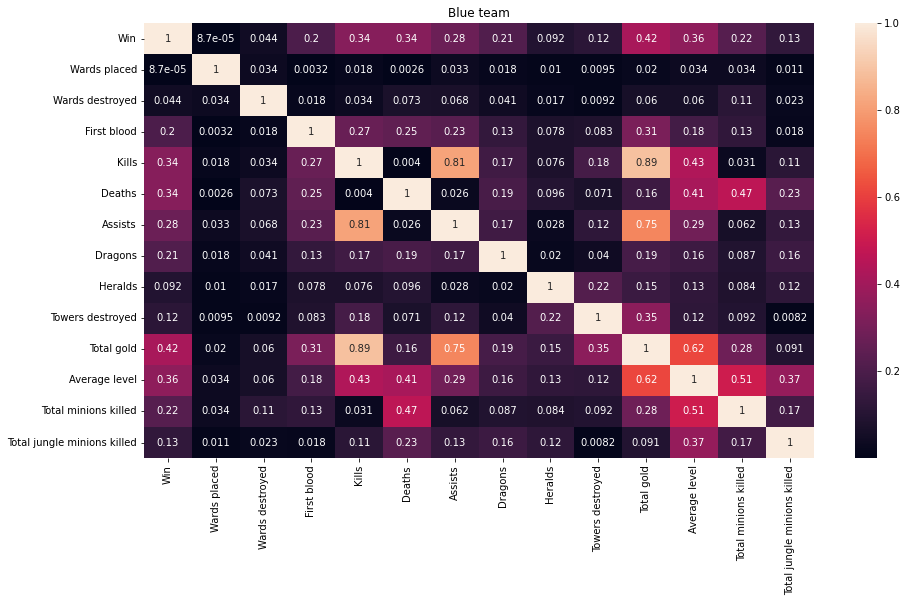

In [5]:
plt.figure(figsize = (15,8))
plt.title("Blue team")
sns.heatmap(df_blue.corr().abs(), annot = True)

There are no surprising results that can be observed from this heatmap. Total gold has a strong positive correlation with winning, since gold allows you to buy items that make you stronger. Hence there is a strong positive correlation between the amount of gold a player has and the amount of kills a player makes. Since kills award a certain amount of experience, the amount of kills also has a strong positive correlation with the average level of a player. On the other hand, all these features have a negative correlation with the amount of deaths a player has.

The only observation that stands out is that heralds seemingly do not contribute much to a win. Having a herald deployed against you in a lane in the game can be quite unforgiving, but it seems that it does not influence the game as much as a player would think.

## Training models

This section will deal with creating predictive models and training them. These models will be able to predict whether or not a game of League of Legends can be won after ten minutes according to a certain accuracy, given a set of input data for which patterns will be analyzed in the training proces. Eventually, different model types will be compared to each other after hyperparameter optimization to ultimately find the best one for this use case.

### Preprocessing data

Redudant features and features that contained data that could be derived were already removed, but now features that show little variance will be removed as well. This process is called feature engineering or feature extraction.

#### Feature engineering

In [6]:
# Remove reduntant data, or data that can be derived
columns = blue_columns + red_columns[1:]
df = df[columns]

# Give the columns a more human readable name
column_names = ['Win', 'Blue wards placed', 'Blue wards destroyed', 'Blue first blood', 'Blue kills', 'Blue deaths',
                'Blue assists', 'Blue dragons', 'Blue heralds', 'Blue towers destroyed',
                'Blue total gold', 'Blue average level', 'Blue total minions killed','Blue total jungle minions killed',
                'Red wards placed', 'Red wards destroyed', 'Red first blood', 'Red kills', 'Red deaths', 'Red assists',
                'Red dragons', 'Red heralds', 'Red towers destroyed', 'Red total gold',
                'Red average level', 'Red total minions killed', 'Red total jungle minions killed']
df.columns = column_names

In [7]:
# We remove the features that have a low variance in their values using VarianceThreshold of SciKit.
sel = VarianceThreshold(threshold = (.8 * (1 - .8)))
sel.fit(df)
# We get the indices of the columns that will be retained because their variance is high enough.
retained_columns = sel.get_support(indices=True)
retained_column_names = []

print("The statistics that have a high enough variance are:")
for i in retained_columns:
    retained_column_names.append(column_names[i])
    print(f" - {column_names[i]}")
    
# We have a look at what columns are removed as well.
all_columns = [i for i in range(len(df.columns))]
removed_columns = list(set(all_columns) - set(retained_columns))
removed_column_names = []

print("\nThe statistiscs that have too low of a variance are:")
for i in removed_columns:
    removed_column_names.append(column_names[i])
    print(f" - {column_names[i]}")

The statistics that have a high enough variance are:
 - Win
 - Blue wards placed
 - Blue wards destroyed
 - Blue first blood
 - Blue kills
 - Blue deaths
 - Blue assists
 - Blue dragons
 - Blue total gold
 - Blue total minions killed
 - Blue total jungle minions killed
 - Red wards placed
 - Red wards destroyed
 - Red first blood
 - Red kills
 - Red deaths
 - Red assists
 - Red dragons
 - Red total gold
 - Red total minions killed
 - Red total jungle minions killed

The statistiscs that have too low of a variance are:
 - Blue heralds
 - Blue towers destroyed
 - Blue average level
 - Red heralds
 - Red towers destroyed
 - Red average level


Since these features have a low variance, they will not influence the outcome of a game much. These features can thus be considered irrelevant during the training of the model.

In [8]:
df.drop(columns=removed_column_names, axis=1, inplace=True)

# Print retained columns of the dataset with their min and max values
print("Entries now have the following remaining columns:")
print(f"\n\t{'Column':32s} | {'Type':8s} | {'Min':8s} | {'Max':8s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:32s} | {str(col.dtype):8s} | {col.min():8.1f} | {col.max():8.1f}")

Entries now have the following remaining columns:

	Column                           | Type     | Min      | Max     

	Win                              | int64    |      0.0 |      1.0
	Blue wards placed                | int64    |      5.0 |    250.0
	Blue wards destroyed             | int64    |      0.0 |     27.0
	Blue first blood                 | int64    |      0.0 |      1.0
	Blue kills                       | int64    |      0.0 |     22.0
	Blue deaths                      | int64    |      0.0 |     22.0
	Blue assists                     | int64    |      0.0 |     29.0
	Blue dragons                     | int64    |      0.0 |      1.0
	Blue total gold                  | int64    |  10730.0 |  23701.0
	Blue total minions killed        | int64    |     90.0 |    283.0
	Blue total jungle minions killed | int64    |      0.0 |     92.0
	Red wards placed                 | int64    |      6.0 |    276.0
	Red wards destroyed              | int64    |      0.0 |     24.0
	Red first

#### Splitting data

PH - Splitting data

In [9]:
train_df_size = 0.7
rest_df_size = 1 - train_df_size
test_df_size = 0.5

train_df, rest_df = train_test_split(df, test_size=rest_df_size)
val_df, test_df = train_test_split(rest_df, test_size=test_df_size)

X_train = train_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] # can be written with list(set(df[features])-set(df[target])))
y_train = train_df.iloc[:,[0]]

X_val = val_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] # can be written with list(set(df[features])-set(df[target])))
y_val = val_df.iloc[:,[0]]

X_test = test_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] # can be written with list(set(df[features])-set(df[target])))
y_test = test_df.iloc[:,[0]]

print("Partitioning of the data:\n")
print(f" - Train data: {len(train_df)} samples (70% of the data).")
print(f" - Validation data: {len(val_df)} samples (15% of the data).")
print(f" - Test data:  {len(test_df)} samples (15% of the data).")

Partitioning of the data:

 - Train data: 6915 samples (70% of the data).
 - Validation data: 1482 samples (15% of the data).
 - Test data:  1482 samples (15% of the data).


### Training models

PH - Training models

#### KNN classificatier

PH - KNN classification + hyperparameter optimisation

In [35]:
ks = [1, 2, 3, 4, 5, 8, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000]
knn_scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train['Win'].to_numpy())
    score = np.mean(cross_val_score(knn, X_val, y_val['Win'].to_numpy(), cv=4))
    knn_scores.append(score)
    print(f"k = {k}: score = {score}")

k = 1: score = 0.6241676986960005
k = 2: score = 0.6295421432213885
k = 3: score = 0.6470951409630654
k = 4: score = 0.666666059590588
k = 5: score = 0.6740930283383114
k = 8: score = 0.6916551322211699
k = 10: score = 0.7058115393021053
k = 15: score = 0.7098546659867415
k = 20: score = 0.7098637721279231
k = 25: score = 0.7159357470678226
k = 50: score = 0.7172852771909375
k = 75: score = 0.7246922124280615
k = 100: score = 0.7253660668755009
k = 200: score = 0.7246976761127705
k = 300: score = 0.724701318569243
k = 400: score = 0.7253733517884461
k = 500: score = 0.7253769942449187
k = 750: score = 0.7199734100677497
k = 1000: score = 0.7193068405332557


PH - Too high of a k is not good either, it goes down -- there is an explanation for this.

k = 500 yields the highest result, namely 0.7253769942449187


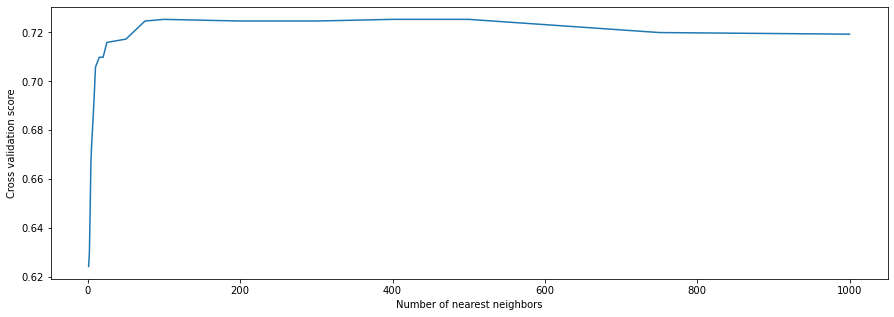

In [36]:
max_score = max(knn_scores)
k_max_score = ks[knn_scores.index(max_score)]

plt.figure(figsize=(15,5))
plt.ylabel("Cross validation score")
plt.xlabel("Number of nearest neighbors")
sns.lineplot(x=ks, y=knn_scores)

print(f"k = {k_max_score} yields the highest result, namely {max_score}")

#### Decision tree classifier

PH - Decision tree classifier + hyperparameter optimisation

In [37]:
# Decision techniques to consider for the decision tree classifier
params = {
    'criterion':  ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

# We can try all of these using GridSearchCV by Scikit.
clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=4, # cross validation
    n_jobs=5, # jobs in parallel
    verbose=1,
)

clf.fit(X_val, y_val)
best_tree_pms = clf.best_params_

print(f"\nBest techniques for the tree are:")
for pm in best_tree_pms.keys():
    print(f" - {pm} = {best_tree_pms[pm]}")

Fitting 4 folds for each of 4 candidates, totalling 16 fits

Best techniques for the tree are:
 - criterion = entropy
 - splitter = random


PH - Describe the best parameter values + try different depths

In [38]:
ds = [1, 2, 3, 4, 5, 8, 10, 15, 20, 25, 50]
tree_scores = []

for d in ds:
    tree = DecisionTreeClassifier(criterion=best_tree_pms['criterion'], splitter=best_tree_pms['splitter'], max_depth=d).fit(X_train, y_train['Win'].to_numpy())
    score = np.mean(cross_val_score(tree, X_val, y_val['Win'].to_numpy(), cv=4))
    tree_scores.append(score)
    print(f"depth = {d}: score = {score}")

depth = 1: score = 0.6248014861222408
depth = 2: score = 0.6356359729001239
depth = 3: score = 0.6639706418008304
depth = 4: score = 0.6714048954614993
depth = 5: score = 0.6794875063742989
depth = 8: score = 0.6646408537917972
depth = 10: score = 0.6457437896117142
depth = 15: score = 0.6039101770233846
depth = 20: score = 0.6093228673417352
depth = 25: score = 0.6356122969330515
depth = 50: score = 0.6214704596780068


PH - General discussion, advantages and disadvantages of depth

depth = 5 yields the highest result, namely 0.6794875063742989


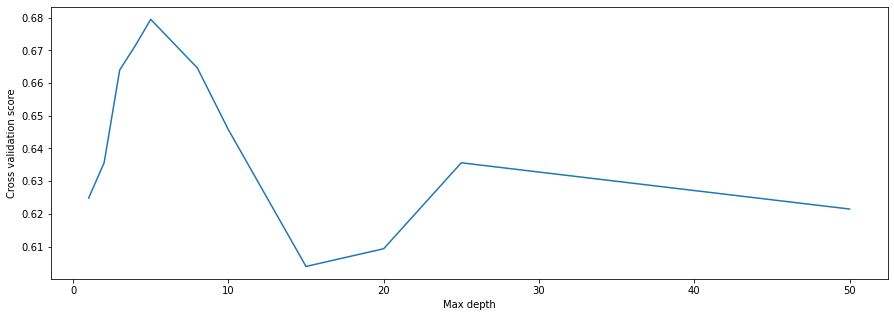

In [39]:
max_score = max(tree_scores)
tree_max_score = ds[tree_scores.index(max_score)]

plt.figure(figsize=(15,5))
plt.ylabel("Cross validation score")
plt.xlabel("Max depth")
sns.lineplot(x=ds, y=tree_scores)

print(f"depth = {tree_max_score} yields the highest result, namely {max_score}")

PH - Discuss best max depth

#### Neural network

PH - first normalise the features of the training data, so the independent variables are scaled between 0 and 1. The dependent variable remains unchanged.

In [40]:
# Normalise the independent variables
X_val_norm = X_val/X_val.max()

# Get the numpy arrays for the input of the neural network
Nn_x = X_val_norm.values
Nn_y = y_val['Win'].to_numpy()

PH - explain amount of hidden layers and neurons -> number of hidden layers and neurons per layer in 'Introduction to Neural Networks for Java' (second edition) by Jeff Heaton.

!! explain relu & adam

In [41]:
# Determine parameters of neural network
n_features = len(Nn_x[0])
n_neurons = int((n_features * 2) / 3)

# Train the neural networks
mlp = MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', max_iter=1000)
mlp.fit(Nn_x, Nn_y)
prediction = mlp.predict(Nn_x)

In [42]:
# We can do this for every model on the test data - perhaps with a boxplot
print(classification_report(Nn_y, prediction))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       732
           1       0.71      0.74      0.73       750

    accuracy                           0.72      1482
   macro avg       0.72      0.72      0.72      1482
weighted avg       0.72      0.72      0.72      1482



#### Logistic Regression

Another method we can try is logistic regression. This is a supervised learning method that can be used to predict a binary target value (true/false, 1/0, yes/no). In other words, it will estimate the probability of an event occuring or not. Since our League of Legends games are either won or lost, we can use this learning method to train a model that can predict the outcome.

A good way to think about this is an S-shaped curve. For certain x-values it will yield an output of y = 0, whereas at a certain point, it will jump up to y = 1, hence the S-shape. This is called the sigmoid function. It all comes down to finding a value for y (also called a threshold value) where we can draw a line (also called the threshold), that can separate these two output values (0/1, win/loss). Every point above this threshold line will yield y = 1, every point underneath will yield y = 0. In the following example we can see a simple example of the sigmoid function and a threshold for threshold value 0.5.

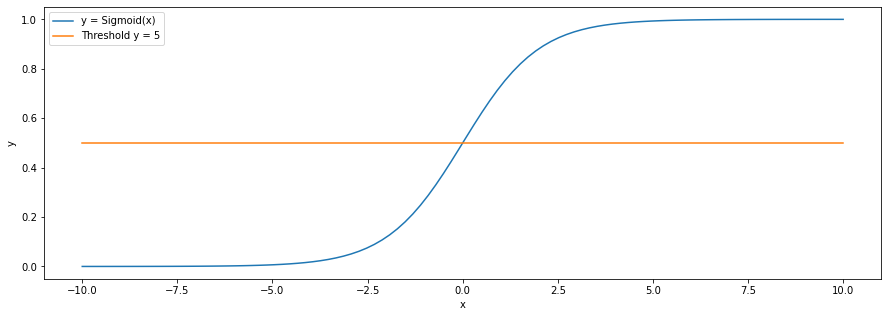

In [43]:
# Sigmoid function and a threshold for threshold value 0.5
x = np.linspace(-10, 10, 100)
y = 1/(1 + np.exp(-x))
threshold = np.full((100, 1), 0.5)

# Drawing the sigmoid function and threshold
plt.figure(figsize=(15,5))
plt.plot(x, y, label="y = Sigmoid(x)")
plt.plot(x,threshold, label="Threshold y = 5")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

To train a logistic regression model, we once again use Scikit's API. Since the Scikit API uses the 'Limited-memory Broyden–Fletcher–Goldfarb–Shanno' algorithm, the algorithm first failed to converge. However, increasing the amount of iterations of the algorithm to 1000 (default value was 100), caused the error of solving to only vary by a small range, thus letting it converge.

In [44]:
# Train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train["Win"].to_numpy())

# Calculate the score using cross validation
logreg_score = np.mean(cross_val_score(logreg, X_val, y_val['Win'].to_numpy(), cv=4))
print(logreg_score)

0.7071683543381656


The model scores relatively well, but alas it is not much different from the previous approaches.

#### Naive Bayes

Another machine learning algorithm we could try is the Naive Bayes algorithm. It will determine the probability of a case belonging to a class. This algorithm works better on categorical input features, rather than numerical which is not the case in this project - if the data is numerical, a normal distribution is assumed. Lastly, it is said that this method requires less training data and predicts better if the assumption of independence holds. Alas, the dataset was downloaded from Kaggle, so this is hard to track. We will continue to test it anyway.

There are several Naive Bayes models that Scikit's API provides, but we will use the Multinomial Naive Bayes algorithm. The models are the following:
* **Gaussian**: used when the features are normally distributed.
* **Multinomial**: used for discrete counts, and since all of our feature data can be seen as counts, e.g. 'amount of kills that occur in a game'.
* **Bernoulli**: used when the features are binary vectors, more in the sense of 'in this game appeared a kill (1), and in the other none occured (0)'.

In [45]:
# Train the multinomial Naive Bayes model
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train['Win'].to_numpy())

# Calculate the score using cross validation
score = np.mean(cross_val_score(nb_clf, X_val, y_val['Win'].to_numpy(), cv=4))
print(score)

0.7220004370947768


We can see that this method barely scores any better than the logistic regression, so either this score can hardly be improved on, or the assumption of independence was not satisfied in the dataset to achieve a better score.

As a final check, we can see if the Naive Bayes model truly needs less training data to achieve the accuracy. We will reduce the training data to 1000 entries.

In [49]:
# Train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train[:1000], y_train[:1000]["Win"].to_numpy())

# Calculate the score using cross validation
logreg_score = np.mean(cross_val_score(logreg, X_val, y_val['Win'].to_numpy(), cv=4))
print(f"Score of the Logistic Regression model with less training data: {round(logreg_score * 100, 3)}%")

# Train the multinomial Naive Bayes model
nb_clf = MultinomialNB()
nb_clf.fit(X_train[:1000], y_train[:1000]["Win"].to_numpy())

# Calculate the score using cross validation
nb_score = np.mean(cross_val_score(nb_clf, X_val, y_val['Win'].to_numpy(), cv=4))
print(f"Score of the Naive Bayes model with less training data: {round(nb_score * 100, 3)}%")

Score of the Logistic Regression model with less training data: 70.717%
Score of the Naive Bayes model with less training data: 72.2%


We can see that the difference in score is about the same for the models that were trained on the full training data set. It does not seem like the Naive Bayes algorithm benefits from the mentioned advantages with this data set. They both perform equally well on less training data.